# **Transfer Learning on Audio**

In [ ]:
from google.colab import files

uploaded = files.upload()

# Make sure the kaggle.json file is present.
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [ ]:
# Create a Kaggle directory and move the kaggle.json file there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d sripaadsrinivasan/audio-mnist
!unzip -q audio-mnist.zip -d /content/audio-mnist


Dataset URL: https://www.kaggle.com/datasets/sripaadsrinivasan/audio-mnist
License(s): CC0-1.0
100% 946M/948M [00:42<00:00, 26.1MB/s]
100% 948M/948M [00:42<00:00, 23.2MB/s]


In [ ]:
!ls /content/audio-mnist/data


01  04	07  10	13  16	19  22	25  28	31  34	37  40	43  46	49  52	55  58	audioMNIST_meta.txt
02  05	08  11	14  17	20  23	26  29	32  35	38  41	44  47	50  53	56  59
03  06	09  12	15  18	21  24	27  30	33  36	39  42	45  48	51  54	57  60


In [ ]:
!pip install librosa tensorflow_hub


In [ ]:
import librosa
import numpy as np
import os

def load_audio_files(directory, sample_rate=16000):
    """
    Load audio files with their labels from the specified directory.

    Args:
    directory (str): Directory where audio files are stored.
    sample_rate (int): Sample rate to use for loading audio files.

    Returns:
    tuple: Tuple containing two lists - audio data and labels.
    """
    audio_files = []
    labels = []
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                # Construct the full file path
                file_path = os.path.join(subdir, file)
                # Load the audio file
                audio, _ = librosa.load(file_path, sr=sample_rate)
                audio_files.append(audio)
                # Extract label from the directory name
                label = int(os.path.basename(subdir))
                labels.append(label)
    return audio_files, labels

# Load audio data and labels
audio_files, labels = load_audio_files('/content/audio-mnist/data')
print(f"Loaded {len(audio_files)} audio files from {len(set(labels))} categories.")





Loaded 30000 audio files from 60 categories.


In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

# Load the YAMNet model
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)


In [ ]:
def extract_features(audio_files):
    # List to hold the extracted features and labels
    features = []
    for audio in audio_files:
        # YAMNet expects a waveform as input
        waveform = tf.convert_to_tensor(audio, dtype=tf.float32)
        waveform = tf.reshape(waveform, [-1])  # Flatten the waveform to ensure it's 1D
        scores, embeddings, spectrogram = yamnet_model(waveform)
        features.append(embeddings.numpy().mean(axis=0))  # Average the embeddings over time
    return np.array(features)


In [ ]:
# Assuming `audio_files` is a list of numpy arrays loaded earlier
audio_features = extract_features(audio_files)
print("Extracted features from", len(audio_features), "files")


Extracted features from 30000 files


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Prepare the labels (assuming 'labels' array is already loaded)
unique_labels = list(set(labels))
label_indices = [unique_labels.index(label) for label in labels]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(audio_features, label_indices, test_size=0.2, random_state=42)

# Create and train the classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

# Evaluate the classifier
predictions = classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Classifier accuracy:", accuracy)


Classifier accuracy: 0.4861666666666667


In [ ]:
# Save the trained model
import joblib
model_path = '/content/audio_classifier.joblib'
joblib.dump(classifier, model_path)

# To load and test the model
loaded_classifier = joblib.load(model_path)
test_predictions = loaded_classifier.predict(X_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print("Test accuracy after reload:", test_accuracy)


Test accuracy after reload: 0.4861666666666667


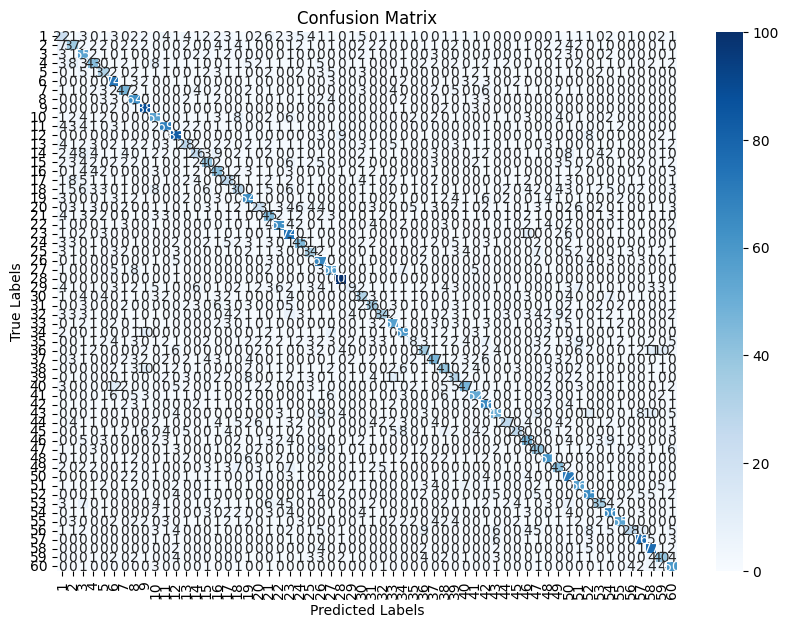

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


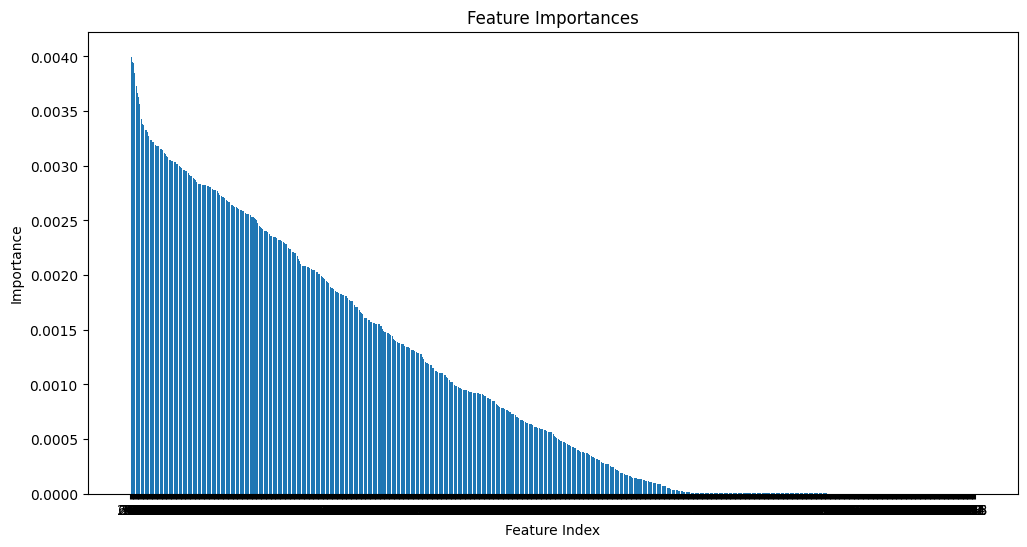

In [ ]:
feature_importances = classifier.feature_importances_
indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), indices)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()
